## PCA 

Algorithm first finds the direction of maximum variance (component 1). This is the direction (or vector) in the data that contains most of the information

- Direction along which the features are most correlated with each other.

In [26]:
import numpy as np
import mglearn as mglearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


## Relevance of features to distinguish a class

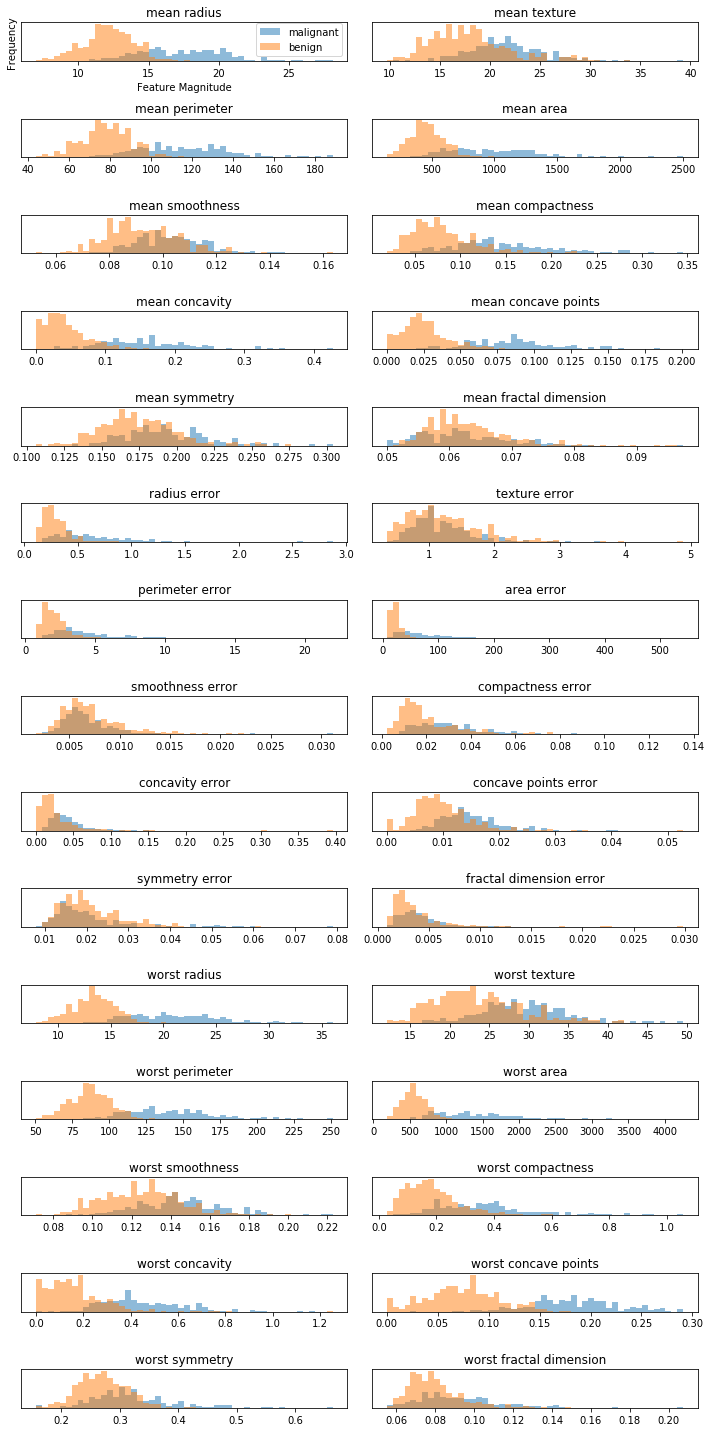

In [20]:
fig, axes = plt.subplots(15,2,figsize=(10,20))
malignant = bunch.data[bunch.target==0]
benign = bunch.data[bunch.target == 1]

ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(bunch.data[:, i], 
                           bins=50)
    ax[i].hist(malignant[:, i], 
               bins = bins, 
               alpha=.5)
    ax[i].hist(benign[:, i],
               bins = bins,
               alpha=.5)
    ax[i].set_title(bunch.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel('Feature Magnitude')
ax[0].set_ylabel('Frequency')
ax[0].legend(['malignant', 'benign'], loc='best')
fig.tight_layout()

In [27]:
bunch = load_breast_cancer()

scaler = StandardScaler()
scaler.fit(bunch.data)
X_scaled = scaler.transform(bunch.data)

# Keep the first two principal components 
pca = PCA(n_components = 2)
pca.fit(X_scaled)
x_pca = pca.transform(X_scaled)

In [22]:
bunch.data.shape

(569, 30)

In [24]:
x_pca.shape

(569, 2)

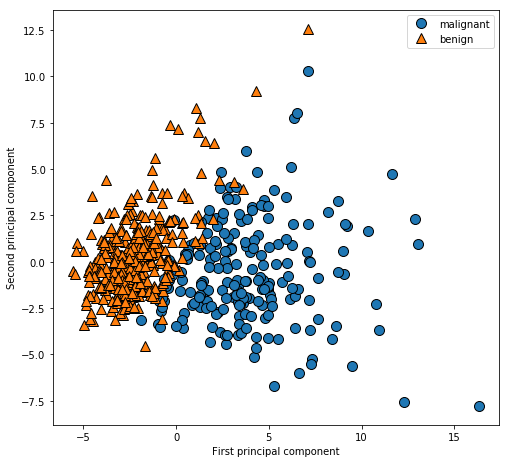

In [31]:
plt.figure(figsize=(8,8))
mglearn.discrete_scatter(x_pca[:, 0],
                         x_pca[:, 1],
                         bunch.target)
plt.legend(bunch.target_names, loc = 'best')
plt.gca().set_aspect('equal')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()


In [36]:
pca.components_.shape

(2, 30)

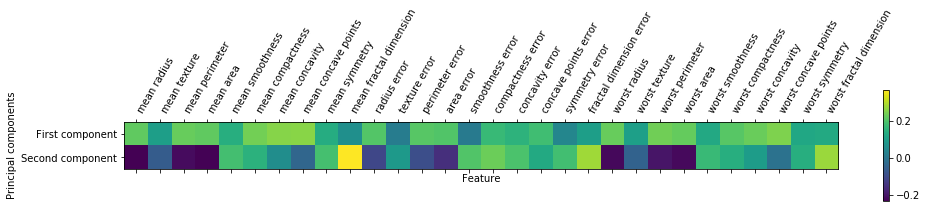

In [42]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0,1], ['First component', 'Second component'])
plt.colorbar()
plt.xticks(range(len(bunch.feature_names)),
          bunch.feature_names, rotation=60, 
          ha = 'left')
plt.xlabel('Feature')
plt.ylabel('Principal components')
plt.show()

## Eigenfaces for feature extraction

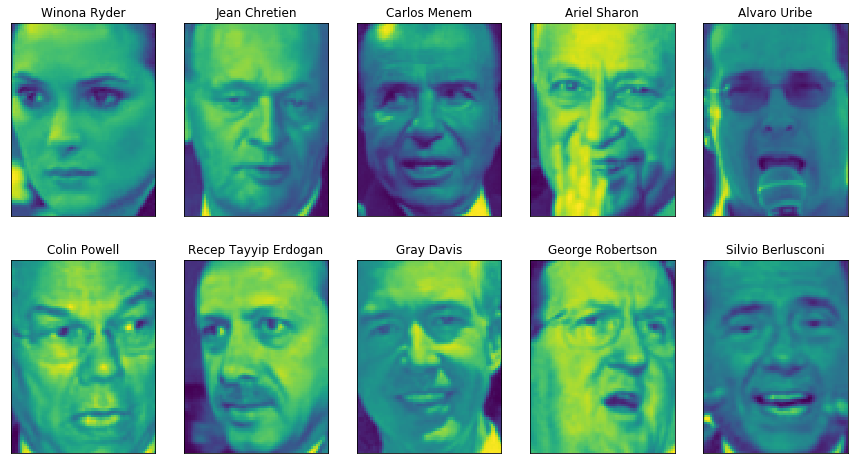

In [49]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20,
                         resize=0.7)
image_shape = people.images[0].shape

fig, axes = plt.subplots(2, 5, figsize=(15,8),
                        subplot_kw={'xticks': (),
                                   'yticks': ()})
for target, image, ax in zip(people.target,
                            people.images,
                            axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])


In [50]:
people.images.shape

(3023, 87, 65)

There are 3023 images, each 87x65 pixels large, belonging to 62 different people

In [51]:
len(people.target_names)

62

`np.bincount` count the number of ocurrences in each value.

In [54]:
counts = np.bincount(people.target)
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end=' ')
    if (i + 1) % 3 == 0:
        print()
        

Alejandro Toledo           39 Alvaro Uribe               35 Amelie Mauresmo            21 
Andre Agassi               36 Angelina Jolie             20 Ariel Sharon               77 
Arnold Schwarzenegger      42 Atal Bihari Vajpayee       24 Bill Clinton               29 
Carlos Menem               21 Colin Powell              236 David Beckham              31 
Donald Rumsfeld           121 George Robertson           22 George W Bush             530 
Gerhard Schroeder         109 Gloria Macapagal Arroyo    44 Gray Davis                 26 
Guillermo Coria            30 Hamid Karzai               22 Hans Blix                  39 
Hugo Chavez                71 Igor Ivanov                20 Jack Straw                 28 
Jacques Chirac             52 Jean Chretien              55 Jennifer Aniston           21 
Jennifer Capriati          42 Jennifer Lopez             21 Jeremy Greenstock          24 
Jiang Zemin                20 John Ashcroft              53 John Negroponte            31 

Contains 530 photos from George W. Bush. We will take only 50 images for each person.

In [59]:
mask = np.zeros(people.target.shape,
               dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target==target)[0][:50]]= 1

X_people = people.data[mask]
y_people = people.target[mask]
# scale the gray scale value between 0 and 1
# instead of 0 and 255 for better numeric stability
X_people = X_people/255

You often want to be able to add new people easily without needing to retrain a larger model.

- A simple solution is to use nearest-neighbor classifier that looks for the most similar face image to the face you are classifying.



In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people,
                                                   stratify=y_people, random_state=0)
# build KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print('Test set score of 1-nn: {:.2f}'.format(knn.score(X_test,y_test)))


Test set score of 1-nn: 0.23


In [65]:
1/62*100

1.6129032258064515

Random guessing would have been 1.6% accurate. We only correcly identify a person every fourth time.

- This is where PCA comes in!

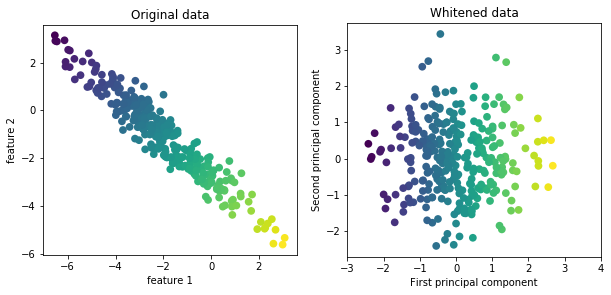

In [66]:
mglearn.plots.plot_pca_whitening()

In [67]:
type(people)

sklearn.utils.Bunch

We add the whitening option to the PCA, which is the same as applying StandardScaler after the transformation.

- We extract the first 100 principal components.

In [99]:
pca = PCA(n_components=100, whiten=True,
         random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_pca.shape

(1547, 100)

- New data has 100 features, the first 100 principal components. Now classify the new representation using a one nearest-neighbors-classifier

In [100]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
knn.score(X_test_pca, y_test)

0.31201550387596899

This confirms our intuition that the PCA components provide a better representation of the data.

In [102]:
pca.components_.shape

(100, 5655)

**For image data, we can visualize the principal components that are found**. 

___

Components correspond to direction in the input space. The input space here is 50x37 pixel grayscale images, so direction within this space are also 50x37 pixel grayscale images.

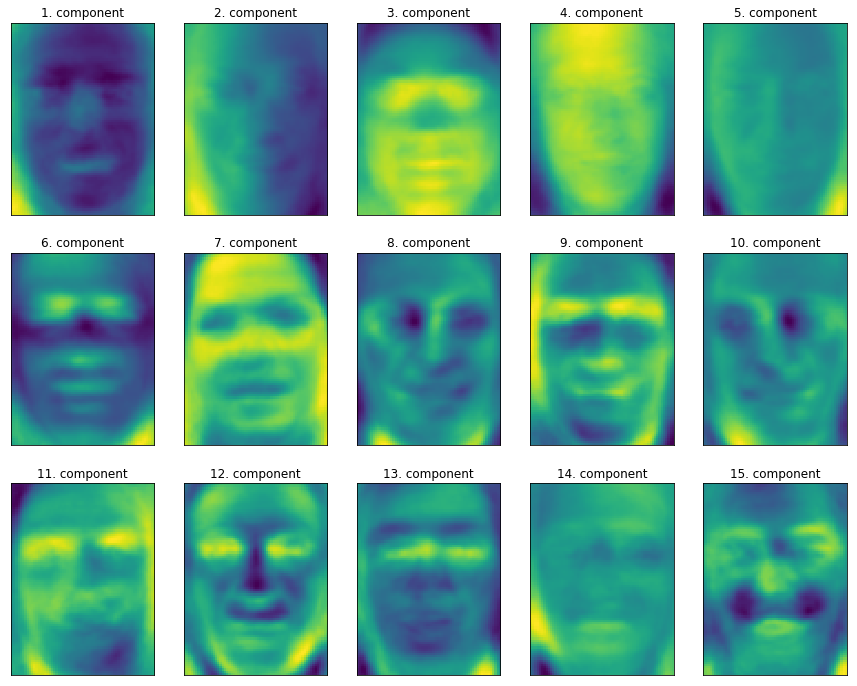

In [108]:
fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                        subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())): 
    ax.imshow(component.reshape(image_shape),
                  cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))

- We cannot understand all aspects of the components, but we can guess which aspects of the face images some of the components are capturing.

- First component mostly encodes the contrast between the face and the background, the second component encodes difference in lighting between the right and the left half of the face.

- The machine encodes differnces in lighting between the right and left half of the face z.B this is quite far from how a human might percieve a face !!

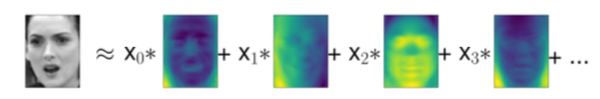

Text(0, 0.5, 'Second Principal Component')

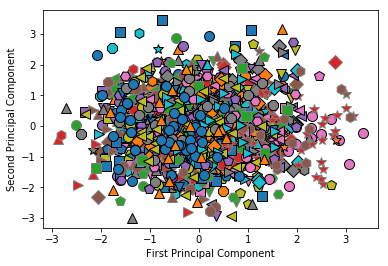

In [109]:
mglearn.discrete_scatter(X_train_pca[:, 0],
                        X_train_pca[:,1], y_train)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

- Using as many components as there are pixels would mean not discard any information after the rotation, and we would reconstruct the image perfectly. 


Using only two principal components is just a big blob, with no separation of classes visible. (This is not very surprising). Given that with 10 components PCA only captures very rough characteristics of the faces.

**Non-Negative Matrix Factorization** (NMF)